## SC-HPC Student Seminar
# Low rank approximating matrices using a randomized SVD

* Nigel Overmars
* SC-HPC OP

# E-NLA Seminar

* Series of talks/seminars on numerical linear algebra
* Biweekly occurrence
* Live on Youtube/Zoom
* Recordings on their Youtube channel
*[Home page](https://sites.google.com/view/e-nla/home)
* [Youtube channel](https://www.youtube.com/channel/UCl3AmvN5JwD4FUJn2aLKDZQ)

# Introduction

* Matrices are a way to store information
* More information $\Longrightarrow$ bigger matrices $\Longrightarrow$ longer processing time
* Not all information is equally useful

![matrix](imagematrix.png)

# Singular value decomposition (SVD)

* Singular value decomposition of a matrix $A \in \mathbb{R}^{m \times n}$
$$A = U\Sigma V^T$$
* $U \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n \times n}$ are orthogonal matrices, $\Sigma \in \mathbb{R}^{m \times n}$ contains the singular values
* Take $x \in \mathbb{R}^n$, then
$$Ax = \sum_{i=1}^{\min(m,n)}\sigma_i u_i v_i^T x$$
* If $\sigma_i$ is small $\Longrightarrow$ encodes little information
* Idea: Drop some (small) singular values to reduce storage

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import ortho_group

# Reduced SVD (of rank $r$)
![rSVD](svd.png)

* Storage = $r(m+n+r)$ vs $m \times n$ doubles/floats
* Useful if $r$ is small

# SVD is optimal

* Low rank approximation: Consider only the first $r$ singular values: $A_r = U_r \Sigma_r V^T_r$
* This is optimal in any unitarily invariant norm (ie induced by inner product)
$$\| A - A_r \| = \| \operatorname{diag} (\sigma_{r+1}, \sigma_{n})\|$$
* Cost of SVD: $\mathcal{O}(mn^2)$
* Advantage: Only has to be calculated once

Text(0, 0.5, 'Runtime (s)')

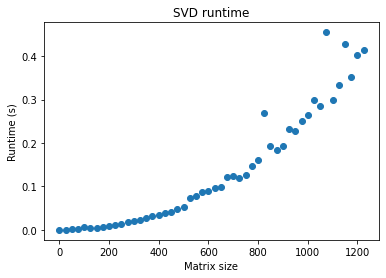

In [21]:
num_itrs = 50
factor = 25
timings = np.zeros([num_itrs, 1])
mat_sizes = [factor * idx for idx in range(num_itrs)]

for itr in range(num_itrs):
    A_mat = np.random.randn(factor * itr, factor * itr)
    start = time.time()
    U_mat, S_mat, Vh_mat = np.linalg.svd(A_mat)
    timings[itr] = time.time() - start
    
fig, ax = plt.subplots()
ax.scatter(mat_sizes, timings)
ax.set_title('SVD runtime')
ax.set_xlabel('Matrix size')
ax.set_ylabel('Runtime (s)')

# Randomized SVD by HMT

* Novel strategy by Halko, Martinsson, Tropp
* Algorithm to approximate $A \in \mathbb{R}^{m \times n}$:

     1) Form random matrix $X \in \mathbb{R}^{n \times r}$,     
     2) Compute $AX \in \mathbb{R}^{m \times r}$,     
     3) Determine thin QR decomposition of $AX$: $AX = QR$, $Q \in \mathbb{R}^{m \times r}$, $R\in \mathbb{R}^{r \times r}$,     
     4) $A \approx Q(Q^TA) =: \hat{A} = Q(U_0\Sigma_0V_0^T) = \hat{U}_0\Sigma_0 V^T_0$ is approximate SVD
     
     
* Cost: $\mathcal{O}(nmr)$, can be reduced to $\mathcal{O}(mn \ln n + mr^2)$
    * At the cost of some accuracy

In [25]:
def gen_exp_matrix(m, n, param):
    # Rapidly decaying singular values with some noise.
    S = np.zeros([m, n])
    for idx in range(n):
        S[idx, idx] = (param ** idx) * np.random.rand()
    U = ortho_group.rvs(m)
    Vt = ortho_group.rvs(n)
    return U @ S @ Vt

In [5]:
def random_SVD(A_mat, X_mat):
    num_rows, num_cols = A_mat.shape

    Q_mat, R_mat = np.linalg.qr(A_mat @ X_mat)
    U_mat, S_vec, Vt_mat = np.linalg.svd(Q_mat.T @ A_mat, full_matrices=False)
    return Q_mat @ U_mat, S_vec, Vt_mat
    

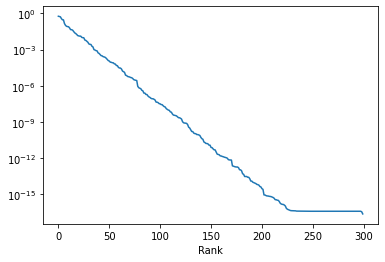

In [26]:
m = 1000
n = 300
param = 0.85
A_mat = gen_exp_matrix(m, n, param)

U_mat, S_vec, Vt_mat = np.linalg.svd(A_mat)

fig, ax = plt.subplots()
ax.plot(range(min(m, n)), S_vec)
ax.set_xlabel('Rank')
ax.set_yscale('log')

# Error estimate on the randomized SVD

* The following error estimate holds ($\hat{r} < r$)
$$\mathbb{E} \| A - \hat{A}\|_F \leq \left(1 + \dfrac{r}{r - \hat{r} - 1} \right)\|A - A_{\hat{r}}\|_F$$
* Important: The probability that the error is bigger decreases exponentially 


# Numerical experiments

* Singular value structure
    * Talk: exponentially decaying
    * What about a random matrix?

* How to sample the matrix $X$?
    * Normal distribution
    * Uniform distribution

In [7]:
def random_SVD_errors(A_mat):
    num_rows, num_cols = A_mat.shape
    max_rank = min(num_rows, num_cols)
    
    errors = np.zeros(max_rank)
    for rank in range(max_rank):
        X_mat = np.random.randn(num_cols, rank)
        U_mat, S_vec, Vt_mat = random_SVD(A_mat, X_mat)
        errors[rank] = np.linalg.norm(A_mat - U_mat @ np.diag(S_vec) @ Vt_mat, 'fro')
    return errors

In [8]:
def SVD_errors(A_mat):
    num_rows, num_cols = A_mat.shape
    max_rank = min(num_rows, num_cols)
    
    errors = np.zeros(max_rank)
    U_mat, S_vec, Vt_mat = np.linalg.svd(A_mat, full_matrices=False)
    for rank in range(max_rank - 1, -1, -1):
        S_vec[rank] = 0.0
        errors[rank] = np.linalg.norm(A_mat - U_mat @ np.diag(S_vec) @ Vt_mat, 'fro')
    return errors

In [9]:
def plot_errors(errorsHMT, errorsSVD):
    length = len(errorsHMT)
    fig, ax = plt.subplots()
    ax.plot(range(length), errors, label = 'HMT')
    ax.plot(range(length), errorsSVD, label = 'SVD')
    ax.set_title('Rank r approximations')
    ax.set_ylabel('Difference in Frobenius norm')
    ax.set_xlabel('Rank')
    ax.set_yscale('log')
    plt.legend()

[1.65984941e+00 1.60073559e+00 1.47503555e+00 1.41931210e+00
 1.27859951e+00 1.30561341e+00 1.32871749e+00 1.29703053e+00
 1.14625160e+00 1.13053504e+00 1.04325178e+00 9.62242987e-01
 9.94705978e-01 9.55725305e-01 9.29548537e-01 8.42874367e-01
 8.03120108e-01 8.19248413e-01 7.82397351e-01 7.09814778e-01
 6.83026816e-01 6.40736277e-01 6.39432228e-01 5.72890879e-01
 5.53171520e-01 5.42948961e-01 5.04553418e-01 5.01955797e-01
 4.59515481e-01 4.68720137e-01 4.27383672e-01 4.23584458e-01
 4.14058267e-01 3.68514819e-01 3.52039260e-01 3.36096099e-01
 3.16603838e-01 3.40331255e-01 3.24070686e-01 2.67814442e-01
 2.70492830e-01 2.55424721e-01 2.51971557e-01 2.28574626e-01
 2.22434678e-01 2.15676234e-01 2.09550553e-01 2.01363419e-01
 1.82519106e-01 1.83890757e-01 1.67408047e-01 1.57990032e-01
 1.44765676e-01 1.47846931e-01 1.49890498e-01 1.46749764e-01
 1.44419800e-01 1.21571491e-01 1.25486704e-01 1.26574773e-01
 1.04221567e-01 1.08037999e-01 1.10062439e-01 9.97104888e-02
 9.29086853e-02 9.062684

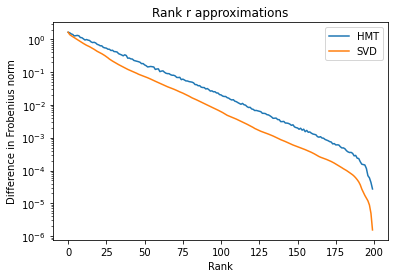

In [34]:
num_rows = 1000
num_cols = 200
param = 0.95

A_mat = gen_exp_matrix(num_rows, num_cols, param)
# A_mat = np.random.rand(num_rows, num_cols)
#A_mat = np.random.randn(num_rows, num_cols)

errors = random_SVD_errors(A_mat)
errorsSVD = SVD_errors(A_mat)

print(errors)
plot_errors(errors, errorsSVD)

# Questions to discuss

* How can we improve the result with slowly decreasing singular values?
* Can we trade accuracy for speed?

# Thanks for listening!


In [15]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/cLm2bawNKC8" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>